In [1]:
"""
该模块定义了两个用于文本分类的类，分别使用BERT和BERT与LSTM结合。
类:
    BertClassifier: 使用BERT进行文本分类的分类器。
    BertLstmClassifier: 使用BERT和双向LSTM进行文本分类的分类器。
类:
    BertClassifier:
        方法:
            __init__(self, bert_config, num_labels): 使用给定的BERT配置和标签数量初始化BertClassifier。
            forward(self, input_ids, attention_mask=None, token_type_ids=None): 定义BertClassifier的前向传播。
    BertLstmClassifier:
        方法:
            __init__(self, bert_config, num_labels): 使用给定的BERT配置和标签数量初始化BertLstmClassifier。
            forward(self, input_ids, attention_mask=None, token_type_ids=None): 定义BertLstmClassifier的前向传播。
"""


import torch.nn as nn
from transformers import BertModel, BertTokenizer


class BertClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        # 定义BERT模型
        self.bert = BertModel(config=bert_config)
        # 定义分类器
        self.classifier = nn.Linear(bert_config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)
        return logits
    
    
class BertLstmClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        self.bert = BertModel(config=bert_config)
        self.lstm = nn.LSTM(bert_config.hidden_size, bert_config.hidden_size, num_layers=2,batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(bert_config.hidden_size * 2, num_labels) ## 双向LSTM
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        logits = self.classifier(lstm_output[:, -1, :])
        return logits

/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from torch.utils.data import Dataset
import json
import numpy as np
import torch

class _2016Dataset(Dataset):
    def __init__(self, file_path, tokenizer,max_length=512):
        self.labels = ['moved', 'angry', 'funny', 'sad', 'novel', 'shocked']
        self.labels_id = {label: i for i, label in enumerate(self.labels)}
        self.tokenizer = tokenizer
        self.input_ids = []
        self.token_type_ids = []
        self.attention_mask = []
        self.label_id = []
        self.load_data(file_path,max_length)

        
    def load_data(self, file_path,max_length=512):
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            
        for item in data:
            text = item['news']
            # 过滤掉不需要的字段
            emotions = {k: v for k, v in item.items() if k in self.labels}
            # 找到值最大的情感字段
            label = max(emotions, key=emotions.get)
            label_id = self.labels_id[label]
            token = self.tokenizer(text, max_length=max_length, add_special_tokens=True, padding='max_length', truncation=True, return_tensors='pt')
            self.input_ids.append(token['input_ids'].clone().detach().to(dtype=torch.long))
            self.token_type_ids.append(token['token_type_ids'].clone().detach().to(dtype=torch.long))
            self.attention_mask.append(token['attention_mask'].clone().detach().to(dtype=torch.long))
            self.label_id.append(label_id)
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index].squeeze(0), self.token_type_ids[index].squeeze(0), self.attention_mask[index].squeeze(0), self.label_id[index]

tokenizer = BertTokenizer.from_pretrained('model/bert-base-chinese')
test_data = _2016Dataset('data/2016.json', tokenizer)

print(len(test_data))

# 获取第一条数据
input_ids, token_type_ids, attention_mask, label_id = test_data[0]

# 解码 input_ids
decoded_text = tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True)

print("解码后的文本:", decoded_text)
print("情感标签ID:", label_id)
print("情感标签名称:", test_data.labels[label_id])


5257
解码后的文本: 媒 体 揭 课 程 辅 导 乱 象 : 让 学 员 续 费 是 老 师 首 要 任 务 暑 假 期 间 ， 不 少 孩 子 参 加 了 各 种 课 程 辅 导 班 。 记 者 调 查 发 现 ， 那 些 宣 称 一 对 一 独 创 教 学 法 的 课 程 辅 导 机 构 ， 不 少 利 用 中 高 考 状 元 高 分 获 得 者 等 进 行 夸 大 宣 传 ， 有 的 一 期 课 程 竟 高 达 5 万 元 ， 而 老 师 的 首 要 任 务 是 让 学 生 不 断 续 费 并 介 绍 新 学 员 。 专 门 招 募 尖 子 生 做 宣 传 培 训 基 本 费 用 每 课 时 200 元 ， 一 个 暑 假 50 个 课 时 ； 一 对 一 辅 导 每 课 时 300 元 ， 一 期 课 程 5 万 多 元 记 者 近 日 走 访 多 地 发 现 ， 暑 期 课 程 辅 导 班 市 场 火 热 。 不 少 机 构 都 打 出 了 培 养 出 中 高 考 状 元 学 员 成 绩 大 幅 提 升 等 宣 传 标 语 。 记 者 对 那 些 写 在 宣 传 单 和 网 站 上 的 成 功 案 例 作 了 分 析 ， 一 些 疑 点 浮 出 水 面 ， 甚 至 还 有 一 些 成 功 案 例 撞 车 的 现 象 。 比 如 在 深 圳 ， 学 而 思 培 优 和 邦 德 两 家 教 育 培 训 机 构 均 宣 称 ， 2015 年 深 圳 市 理 科 中 考 状 元 是 他 们 培 养 的 。 有 些 机 构 专 门 招 募 尖 子 生 进 行 免 费 培 训 ， 主 要 目 的 就 是 在 升 学 考 试 之 后 将 高 分 获 得 者 用 作 宣 传 。 南 京 一 家 教 育 机 构 在 其 2015 年 中 考 喜 报 里 突 出 宣 传 的 南 京 哈 佛 班 学 员 ， 实 际 上 是 今 年 4 月 份 该 机 构 在 南 京 多 所 重 点 中 学 里 集 中 选 拔 出 来 的 尖 子 生 ， 以 免 费 培 训 换 取 中 考 之 后 的 宣 传 权 。 记 者 调 查 发 现 ， 不 少 培 训 机 构 缺 乏 资 质 。 深 圳 市 教 育 局 最 新 发 布 的 《 深 圳 市 教 育 培 训 机
情感标签ID: 1
情感

In [3]:
#分割数据集
import json
import random

# 加载原始数据集
with open('data/2016.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# 打乱数据集
random.shuffle(data)

# 分割数据集
split_index = int(len(data) * 0.7)
train_data = data[:split_index]
test_data = data[split_index:]

# 保存训练集到 train.json
with open('data/train.json', 'w', encoding='utf-8') as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)

# 保存测试集到 test.json
with open('data/test.json', 'w', encoding='utf-8') as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 3679
测试集大小: 1578


In [4]:
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, AdamW, BertConfig
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn import metrics
import scipy.stats as stats  # 引入scipy库

def train():
    model_path = "model/bert-base-chinese"
    data_path = "data/"
    batch_size = 16
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 20
    learning_rate = 5e-5
    tokenizer = BertTokenizer.from_pretrained(model_path)
    
    train_dataset = _2016Dataset(data_path + 'train.json', tokenizer)
    valid_dataset = _2016Dataset(data_path + 'test.json', tokenizer)

    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    bert_config = BertConfig.from_pretrained(model_path)
    num_labels = len(train_dataset.labels)
    
    model = BertClassifier(bert_config, num_labels).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    criterion = nn.CrossEntropyLoss()
    
    best_f1 = 0
    
    # 用于记录每个 epoch 的训练损失、验证损失、训练准确率、验证准确率
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    pearson_corrs = []  # 用于记录每一轮的皮尔逊相关系数
    
    for epoch in range(1, epochs + 1):
        model.train()
        losses = 0
        accuracy = 0
        
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_bar = tqdm(train_dataloader, ncols=100)
        
        for input_ids, token_type_ids, attention_mask, label_id in train_bar:
            
            model.zero_grad()
            train_bar.set_description(f"Epoch {epoch}")
            
            output = model(input_ids.to(device), attention_mask=attention_mask.to(device), token_type_ids=token_type_ids.to(device))

            loss = criterion(output, label_id.to(device))
            
            losses += loss.item()
            
            pred_labels = torch.argmax(output, dim=1)
            acc = torch.sum(pred_labels == label_id.to(device)).item() / len(label_id)
            accuracy += acc
            
            loss.backward()
            optimizer.step()
            train_bar.set_postfix(loss=loss.item(), acc=acc)
            
        average_loss = losses / len(train_dataloader)
        average_acc = accuracy / len(train_dataloader)
        
        # 保存训练损失和准确率
        train_losses.append(average_loss)
        train_accuracies.append(average_acc)
        
        print('\tTrain ACC:', average_acc, '\tLoss:', average_loss)
        
        model.eval()
        losses = 0
        pred_labels = []
        true_labels = []
        valid_bar = tqdm(valid_dataloader, ncols=100)
        
        for input_ids, token_type_ids, attention_mask, label_id in valid_bar:
            valid_bar.set_description(f'Epoch {epoch} valid')

            output = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), token_type_ids=token_type_ids.to(device))
            
            loss = criterion(output, label_id.to(device))
            losses += loss.item()

            pred_label = torch.argmax(output, dim=1)
            acc = torch.sum(pred_label == label_id.to(device)).item() / len(pred_label)
            valid_bar.set_postfix(loss=loss.item(), acc=acc)

            pred_labels.extend(pred_label.cpu().numpy().tolist())
            true_labels.extend(label_id.numpy().tolist())
        
        average_loss = losses / len(valid_dataloader)
        valid_losses.append(average_loss)
        valid_accuracies.append(acc)
        
        print('\tValidation Loss:', average_loss)
        
        # 计算皮尔逊相关系数
        pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)
        pearson_corrs.append(pearson_corr)  # 将每轮的皮尔逊系数添加到列表
        
        print(f'\tPearson Correlation: {pearson_corr}')

        f1 = metrics.f1_score(true_labels, pred_labels, labels=list(valid_dataset.labels_id.values()), average='micro')
        
        if not os.path.exists('models'):
            os.makedirs('models')
        
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'models/best_model_2.pkl')
    
    # 返回训练和验证的损失数据、准确率数据和皮尔逊系数
    return train_losses, valid_losses, train_accuracies, valid_accuracies, pearson_corrs


In [5]:
# 运行训练过程并获取分类报告数据、训练损失和验证损失
train_losses, valid_losses, train_accuracies, valid_accuracies, pearson_corrs = train()


/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████████████████████████| 230/230 [01:24<00:00,  2.73it/s, acc=0.267, loss=1.41]


	Train ACC: 0.3416485507246377 	Loss: 1.5269486302914828


Epoch 1 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.70it/s, acc=0.3, loss=1.35]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5165848202175565
	Pearson Correlation: nan


Epoch 2: 100%|██████████████████████████████| 230/230 [01:25<00:00,  2.70it/s, acc=0.333, loss=1.57]


	Train ACC: 0.3381340579710145 	Loss: 1.5138813288315482


Epoch 2 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.33it/s, acc=0.3, loss=1.41]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.4966786028158785
	Pearson Correlation: nan


Epoch 3: 100%|████████████████████████████████| 230/230 [01:26<00:00,  2.67it/s, acc=0.4, loss=1.39]


	Train ACC: 0.3539130434782609 	Loss: 1.5018287492835003


Epoch 3 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.41it/s, acc=0.3, loss=1.44]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.4991589146431046
	Pearson Correlation: nan


Epoch 4: 100%|██████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.533, loss=1.42]


	Train ACC: 0.3501449275362319 	Loss: 1.5054274761158488


Epoch 4 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.43it/s, acc=0.3, loss=1.42]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.497209040805547
	Pearson Correlation: nan


Epoch 5: 100%|██████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.467, loss=1.33]


	Train ACC: 0.351213768115942 	Loss: 1.5016501675481382


Epoch 5 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.3, loss=1.41]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.500254415502452
	Pearson Correlation: nan


Epoch 6: 100%|████████████████████████████████| 230/230 [01:25<00:00,  2.69it/s, acc=0.6, loss=1.46]


	Train ACC: 0.35043478260869565 	Loss: 1.503815586152284


Epoch 6 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.46it/s, acc=0.3, loss=1.37]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.4957763630934435
	Pearson Correlation: nan


Epoch 7: 100%|████████████████████████████████| 230/230 [01:25<00:00,  2.69it/s, acc=0.4, loss=1.42]


	Train ACC: 0.35010869565217395 	Loss: 1.5042724298394246


Epoch 7 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.3, loss=1.44]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5181946224636502
	Pearson Correlation: nan


Epoch 8: 100%|██████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.333, loss=1.45]


	Train ACC: 0.34927536231884054 	Loss: 1.5014232324517292


Epoch 8 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.3, loss=1.38]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.4944018005120634
	Pearson Correlation: nan


Epoch 9: 100%|████████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.2, loss=1.61]


	Train ACC: 0.3560326086956522 	Loss: 1.4980739754179249


Epoch 9 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.43it/s, acc=0.4, loss=1.38]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5156996527103463
	Pearson Correlation: nan


Epoch 10: 100%|███████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.4, loss=1.31]


	Train ACC: 0.35635869565217393 	Loss: 1.4997928764509119


Epoch 10 valid: 100%|███████████████████████████| 99/99 [00:11<00:00,  8.41it/s, acc=0.4, loss=1.42]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5167522406337237
	Pearson Correlation: nan


Epoch 11: 100%|█████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.333, loss=1.64]


	Train ACC: 0.34791666666666665 	Loss: 1.5019397424614949


Epoch 11 valid: 100%|███████████████████████████| 99/99 [00:11<00:00,  8.43it/s, acc=0.4, loss=1.36]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5098292707192777
	Pearson Correlation: nan


Epoch 12: 100%|███████████████████████████████| 230/230 [01:25<00:00,  2.69it/s, acc=0.4, loss=1.34]


	Train ACC: 0.3490217391304348 	Loss: 1.498034473605778


Epoch 12 valid: 100%|███████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.3, loss=1.42]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.4945846699705028
	Pearson Correlation: nan


Epoch 13: 100%|█████████████████████████████| 230/230 [01:25<00:00,  2.69it/s, acc=0.333, loss=1.73]


	Train ACC: 0.3530797101449275 	Loss: 1.4997044744698897


Epoch 13 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.43it/s, acc=0.3, loss=1.4]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.4952387436471803
	Pearson Correlation: nan


Epoch 14: 100%|█████████████████████████████| 230/230 [01:25<00:00,  2.69it/s, acc=0.467, loss=1.27]


	Train ACC: 0.3468659420289855 	Loss: 1.4975405573844909


Epoch 14 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.3, loss=1.4]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5038309338116886
	Pearson Correlation: nan


Epoch 15: 100%|██████████████████████████████| 230/230 [01:25<00:00,  2.69it/s, acc=0.533, loss=1.3]


	Train ACC: 0.34905797101449276 	Loss: 1.50094887536505


Epoch 15 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.3, loss=1.4]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5057498409290506
	Pearson Correlation: nan


Epoch 16: 100%|███████████████████████████████| 230/230 [01:25<00:00,  2.69it/s, acc=0.4, loss=1.73]


	Train ACC: 0.36043478260869566 	Loss: 1.498358730647875


Epoch 16 valid: 100%|███████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.3, loss=1.38]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.502674365284467
	Pearson Correlation: nan


Epoch 17: 100%|█████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.467, loss=1.48]


	Train ACC: 0.34795289855072464 	Loss: 1.4980242236800816


Epoch 17 valid: 100%|████████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.3, loss=1.4]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5062920794342503
	Pearson Correlation: nan


Epoch 18: 100%|███████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.4, loss=1.78]


	Train ACC: 0.34847826086956524 	Loss: 1.5039755437685096


Epoch 18 valid: 100%|███████████████████████████| 99/99 [00:11<00:00,  8.42it/s, acc=0.4, loss=1.37]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.506698413328691
	Pearson Correlation: nan


Epoch 19: 100%|█████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.267, loss=1.46]


	Train ACC: 0.35768115942028983 	Loss: 1.4957275048546168


Epoch 19 valid: 100%|███████████████████████████| 99/99 [00:11<00:00,  8.39it/s, acc=0.3, loss=1.37]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.4983776530834159
	Pearson Correlation: nan


Epoch 20: 100%|█████████████████████████████| 230/230 [01:25<00:00,  2.68it/s, acc=0.467, loss=1.44]


	Train ACC: 0.34740942028985505 	Loss: 1.4978881628616996


Epoch 20 valid: 100%|███████████████████████████| 99/99 [00:11<00:00,  8.41it/s, acc=0.3, loss=1.43]
/tmp/ipykernel_2580036/1951089149.py:106: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = stats.pearsonr(true_labels, pred_labels)


	Validation Loss: 1.5000128432957813
	Pearson Correlation: nan


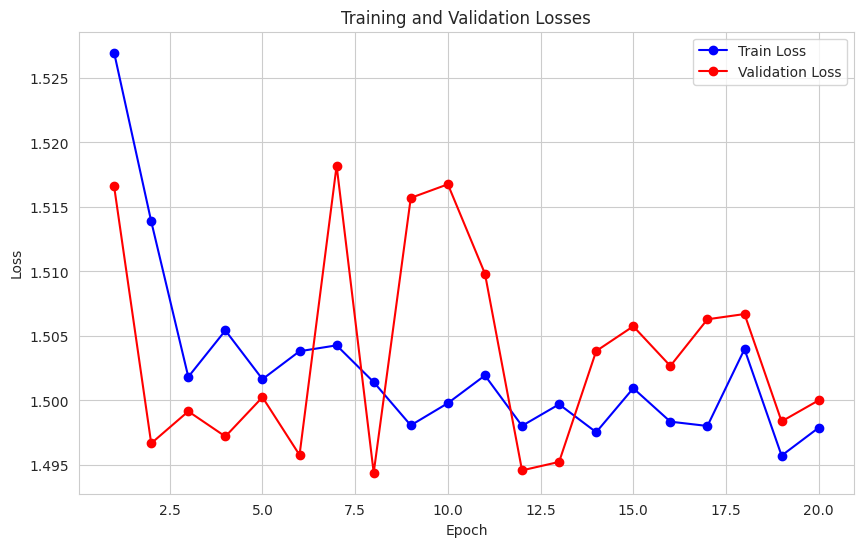

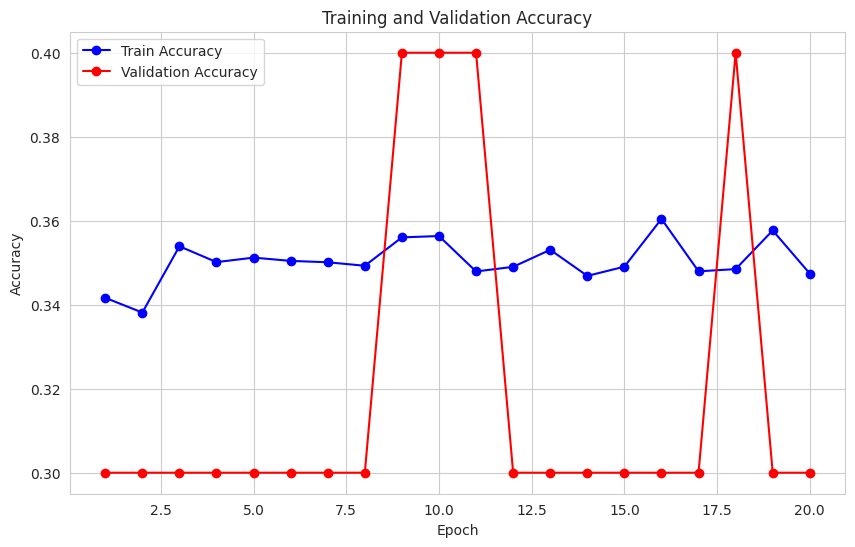

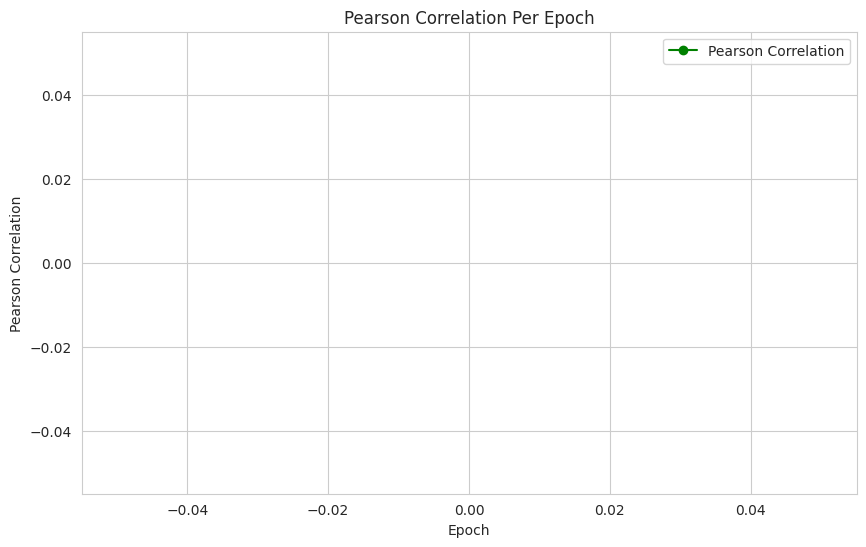

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 调用训练函数并获取结果

# 设置 Seaborn 样式
sns.set_style("whitegrid")

# 绘制训练和验证的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss", color='red', marker='o')
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 绘制训练和验证的准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color='blue', marker='o')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label="Validation Accuracy", color='red', marker='o')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 绘制皮尔逊相关系数曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pearson_corrs) + 1), pearson_corrs, label="Pearson Correlation", color='green', marker='o')
plt.title("Pearson Correlation Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Pearson Correlation")
plt.legend()
plt.grid(True)
plt.show()
